### Développement d'un modèle de classificateur pour prédire le type de panne.

#### Librairies  nécessiare pour le travail

In [71]:
import pandas as pd
import numpy as np
import sklaern as 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import pickle

### Importation des données

In [72]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [73]:
df= pd.read_csv("/home/sacko/Documents/Maintenance/DefaultData.csv")

In [74]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [75]:
df.info()# Information sur les données

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Nous pouvons confirmer d'après l'information fournies par cette analyse, qu'il n'y a pas de valeurs nulles dans les colonnes et que leur type est correct.


In [76]:
# Vérifions l'existance des valeurs dupliquées 
data_duplicates = df.duplicated().sum()
print("Total duplicated values: ", data_duplicates)

Total duplicated values:  0


In [77]:
# Vérifions si les données ont des valeurs manquantes
data_null = df.isnull().sum().sum()
print("Total missing values: ", data_null)

Total missing values:  0


In [78]:
## Analysons les variavles qualitatives numériques
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [79]:
## Vérifions la proportion de la variable "Target"
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [80]:
## Vérifions la proportion de la colonne cible "Failure_type"
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

On peur voir que les modalités de notre variable cible «Failure_type» n'ont de même proportion, à cause de cela, à cet effet, il sera nécessaire d'appliquer une stratégie pour gérer cela afin d'éviter que le modèle ait un surajustement.

In [81]:
## Renommer les colonnes
rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
}
df.rename(rename_columns, axis = 1, inplace = True)

In [82]:
# Comptage des modalités de variable faillore sur la colonne "Cible"
count_failures = (df['Target'] == 1).sum()
print('Number of failures:', count_failures)
# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Sum of failures different of "No Failure":', sum_failures)

Number of failures: 339
Sum of failures different of "No Failure": 330


In [83]:
#Filtrez les lignes avec le has 1 dans la colonne "Target" et "No Failure" dans la colonne "Failure_type"
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]
# Supprimons cette ligne filtrée dans le df principal
df.drop(rows_to_remove.index, inplace=True)

In [84]:
#Suppression des variables inutiles
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)

In [85]:
# Suppression de la modalité "Random Failures" de la variable"Failure_type"
df = df.loc[df['Failure_type'] != 'Random Failures']

In [86]:
## Renommons les classes
rename_type = {
    'L':'Low',
    'M':'Medium',
    'H':'High'
}
df['Type'].replace(rename_type, inplace = True)

### Répartition de la variable «types»

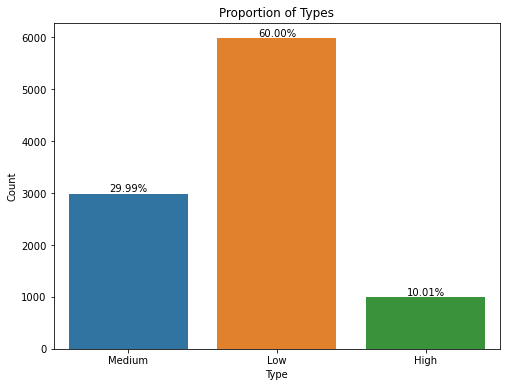

In [87]:
tipo_contagem = df['Type'].value_counts()
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')
plt.show()

On peut voir sur la figure ci-dessus, que la classe «Low» est la classe majoritaire, la classe « High» est la classe minoritaire.

### Répartition de la variable «Failure_type»

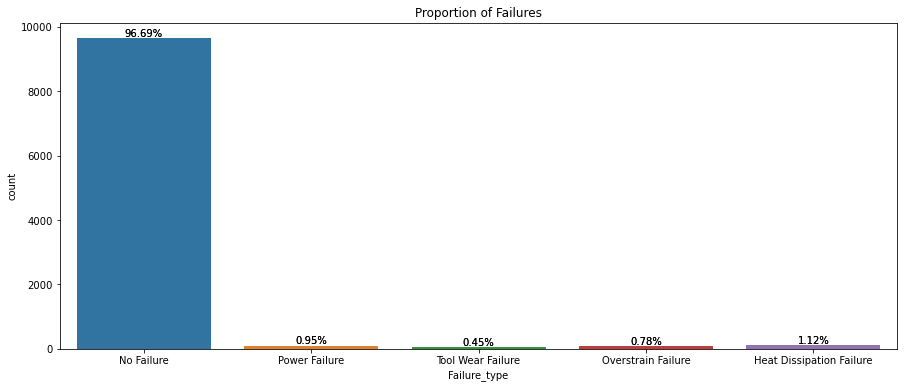

In [88]:
tipo_contagem = df['Failure_type'].value_counts()

plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proportion of Failures')
plt.xlabel('Type')
plt.ylabel('Count')
ax = sns.countplot(data=df, x = 'Failure_type')

total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

Comme nous pouvons le voir sur notre figure ci-dessus, nous avons ici deux problèmes pour modéliser notre modèle. Le premier concerne les classes déséquilibrées, nous devrons appliquer une certaine stratégie pour construire un modèle modeste comme SMOTE-NC par exemple. La seconde est que nous traiterons du problème multiclasse, il est important de toujours y prêter attention.


### Histogramme et boxplot des variables numériques

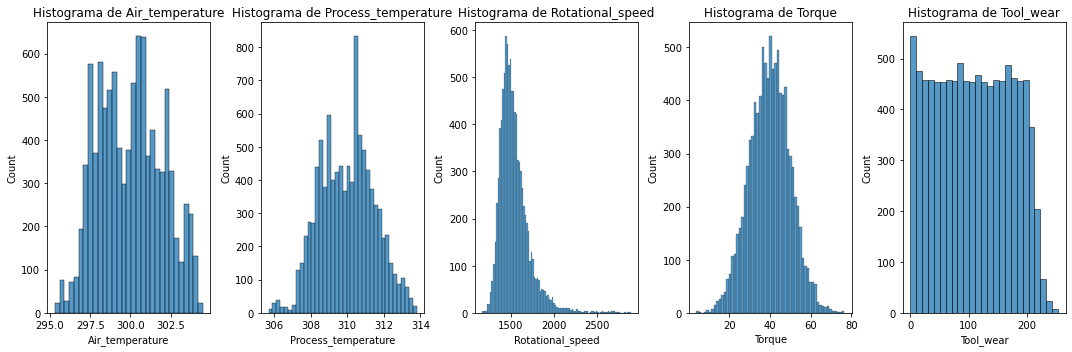

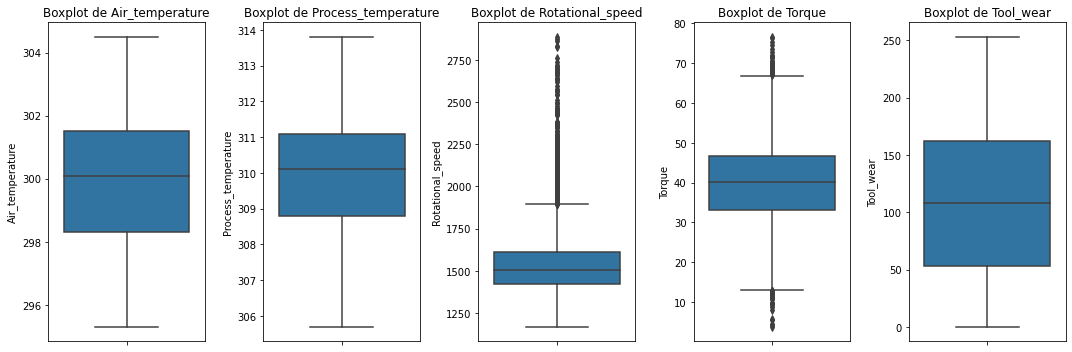

In [24]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Affichage l'histogramme
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Affichage de boxplots
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

plt.tight_layout()


En ce qui concerne l'histogramme ci-dessus, les colonnes Air_temperatura, Process_temperature et torque sont similaires à la distribution normale et rotation_speed est assimétrique avec un biais négatif. En ce qui concerne le boxplot, il est ici possible de confirmer l'hypothèse selon laquelle il existe des valeurs aberrantes dans certaines colonnes. 

### Répartition des modalités échecs

Text(0.5, 1.0, 'Class Distribution')

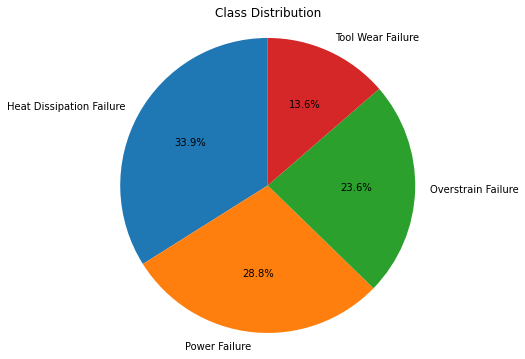

In [25]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.title('Class Distribution')

On peut voir sur notre camembert ci-dessus, qu'il existe une petite partie significative des classes "Tool Wear Failure" par rapport aux autres. Cela peut s'avérer plus difficile pour le modèle de prédire correctement cette classe sans aucune stratégie pour tenter de résoudre ce problème. En général, tous les types de pannes sont déséquilibrés par rapport aux valeurs avec "No Failure". Nous essayerons plus tard de résoudre ce problème pour atténuer cete problématique.


## Matrice de corrélation entre les variables numériques

<AxesSubplot:>

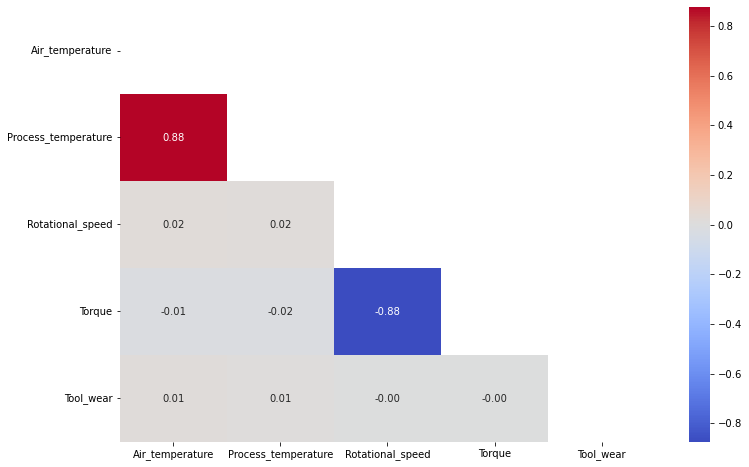

In [26]:
corr = df.corr()
plt.figure(figsize = (12,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")

On constate sur la matrice de confusion que, lorsque la variable "torque" diminue la vitesse de rotation (rotational_speed) est vraie, il existe une corrélation négative expressive entre ces variables (-0,88). De plus, nous pouvons voir maintenant que process_temperature et air_temperature ont également une corrélation expressive, lorsque la température de l'air augmente, la température du processus augmente également.

### Mettons à l'échelle les variables numériques et appliquons OneHotEncoder pour les variables qualitatives

In [28]:
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# Créer le ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])
df_transformed = preprocessor.fit_transform(df)

# Conversion des données transformées en dataframe pour une visualisation plus facile et c'est ne pas obligatoire
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0


### Application d'ACP à notre données transformées.
Noter bien que pour réaliser l'analyse PCA la transformation en dataframe n'est pas nécessaire, nous pouvons appliquer l'analyse PCA peu de temps après pour transformer notre df.

L'ACP (Analyse en Composante Principale) réduit la dimensionnalité des données, met en évidence les individus qui partagent les même caractéristiques et simplifie les ensembles de données, améliorant ainsi les performances et l'interprétabilité du modèle tout en préservant les informations essentielles. Vérifions dans quelle mesure les composants expliquent plus ou moins 95 % de nos données à travers le graphique ci-dessous.

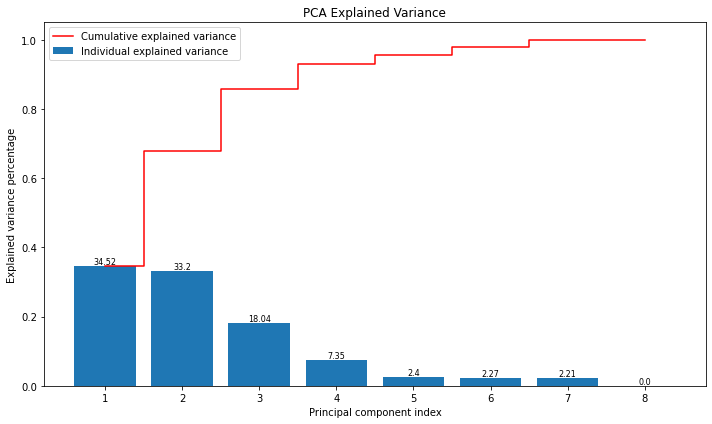

In [39]:
# Définition de la fonction ACP
acp = PCA()
acp.fit(df_transformed)  # On considère que df transformeé est notre DataFrame

# Variances expliquées par ACP
exp_var = acp.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Nombre de composants principales
n_acp_components = len(exp_var)

# Création de graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_acp_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_acp_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Ajout des étiquettes
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2), 
             va='bottom', ha='center', fontsize=8)

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Nous pouvons voir sur la figure ci-dessus, que les  4 premières composantes expliquente environ 94% de la variabilité de nos données. Nous pouvons donc essayer d'utiliser uniquement ces 4 composants pour modéliser et analyser si les performances s'améliorent. 
Dans certains cas, l'ensemble de données peut être critique et la perte d'un certains pourcentages des informations peut empirer le modèle.

### Explication du tracé des composants de ACP

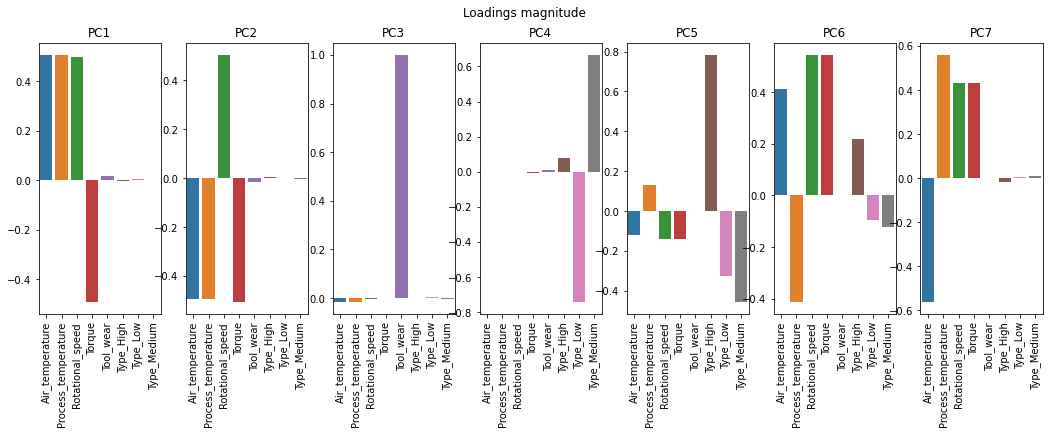

In [35]:
# ACP avec 7 composants pour analyser ce qui explique chaque composant
acp7 = PCA(n_components=7)
X_acp7 = pd.DataFrame(data=acp7.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')

all_features = NUMERIC_FEATURES + list(encoded_feature_names)  # Use encoded_feature_names do 
acp_loadings = pd.DataFrame(data=acp7.components_, columns=all_features)

# Traçage des graphes à barres
for j in range(7):
    ax = axs[j]
    sns.barplot(ax=ax, x=acp_loadings.columns, y=acp_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))

On peut observer, sur la figure ci-dessus que : PC1 et PC2 : expliqués par Air_temperature, Process_temperatura, Rotational_speed et Torque ; PC3 : expliqué par Tool_wear ; PC4 : plus expliqué par Type_Low et Type_Medium ; PC5 : le plus expliqué par Type_High ; PC6 : plus expliqué par Air_temperature, Process_temperatura, Rotational_speed et Torque ; PC7 : le plus expliqué par Air_temperature, Process_temperatura, Rotational_speed et Torque.

## Modeling

Nous avons constaté lors de l'analyse exploratoire, que les classes de notre variable cible "Failure_type" sont déséquilibrées.
Nous testerons diverses techniques pour remédier aux classes déséquilibrées. 
Notre objectif est d'évaluer les performances des modèles avec et sans l'utilisation de ACP. De plus, nous utiliserons SMOTE-NC pour gérer les classes déséquilibre, par la suite, nous explorerons l'utilisation d'hyperparamètres dans le modèle pour équilibrer les classes sans utiliser SMOTE-NC.

### Create a function to get metrics

In [46]:
from sklearn.metrics import f1_score
def get_metrics(y_true, y_pred):
    # Calcul des scores F1 pour chaque classe
    f1_scores_per_class = f1_score(y_true, y_pred, average=None)
    
    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro'),
        'F1 Scores per Class': f1_scores_per_class
    }
    return dict_metrics

### Repartition des données en données d'entrainement et données test

In [47]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

### Création du modèle avec ACP 
À noter que l'ACP est une technique de réduction de dimensionnalité linéaire. Si nos données contiennent des relations non linéaires importantes pour les prédictions, l'ACP pourrait ne pas être en mesure de les capturer efficacement, ce qui entraînerait une diminution des performances du modèle.


###### Compatibilité modèle-données : 
Certains modèles sont plus sensibles à la représentation des fonctionnalités en entrée et peuvent mieux fonctionner avec les fonctionnalités d'origine plutôt qu'avec les composants principaux. Cela peut être dû à diverses raisons, notamment le type d’algorithme, la nature des données et la tâche spécifique à accomplir.

###### Importance des interactions entre les fonctionnalités : 
Si les interactions entre les fonctionnalités d'origine sont importantes pour notre modèle, l'ACP, qui crée des combinaisons linéaires de fonctionnalités, peut perturber ces interactions.

Est-ce que c'est une problématique? Pas nécessairement. Il est important de se rappeler que l'ACP n’est qu’un des nombreux outils de réduction de dimensionnalité et d’extraction de fonctionnalités. Si l'ACP n’améliore pas ou même détériore les performances de notre modèle, il est tout à fait raisonnable de choisir de ne pas l’utiliser.


In [50]:
# Création d'un pipeline avec analyse ACP et classe équilibrée
pip_model_acp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=4)),# 4 premieres composantes de acp
    ('model', RandomForestClassifier(random_state=2024))
])

# Ajustons le pipeline avec ACP
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_acp.fit(X_train, y_train, model__sample_weight=weights)

# Génération des prédictions en utilisant le pipeline ajusté.
y_pred = pip_model_acp.predict(X_test)

# Évaluons les métriques
metrics = get_metrics(y_test, y_pred)
metrics

{'Accuracy': 0.9709273182957393,
 'Balanced Accuracy': 0.2946172248803828,
 'Macro Recall': 0.2946172248803828,
 'Macro Precision': 0.7941620533467539,
 'Macro F1': 0.3435200071057424,
 'F1 Scores per Class': array([0.08695652, 0.98518897, 0.54545455, 0.1       , 0.        ])}

### Création du modèle sans ACP

In [49]:
# Création de pipeline sans analyse ACP et classe équilibrée avec paramètre de  modèle
pip_model_no_acp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=2024))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_acp.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_acp.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.9548872180451128,
 'Balanced Accuracy': 0.8089450719853029,
 'Macro Recall': 0.8089450719853029,
 'Macro Precision': 0.5918666031005705,
 'Macro F1': 0.6555845607554603,
 'F1 Scores per Class': array([0.78571429, 0.97652334, 0.57894737, 0.7804878 , 0.15625   ])}

Comme nous pouvons analyser ici, nous avons obtenu une augmentation significative des performances de notre modèle. Cela confirme l'hypothèse selon laquelle l'utilisation de ACP avec seulement 4 composants a entraîné une perte d'informations, donc utiliser ACP ici n'est pas intéressant. Il est important de se rappeler que notre score cible est le score Macro F1, donc avant nous avions 0,344 et maintenant nous en avons 0,656.


### Création du modèle sans ACP et avec SMOTE-NC
La stratégie ici est d'analyser si le modèle fonctionne mieux quand on gère les classes déséquilibrées avec SMOTE-NC.


In [51]:
# Obtention des indices de variables qualitatives pour SMOTE-NC

categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORIC_FEATURES) 
                                if feature in CATEGORIC_FEATURES]

# Création du nouveau pipeline avec SMOTENC en utilisant ImbPipeline
pip_model_smotenc = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', GradientBoostingClassifier(random_state=2023))
])

pip_model_smotenc.fit(X_train, y_train)

# Predictions
y_pred = pip_model_smotenc.predict(X_test)

# Evaluation de Metrics
metrics = get_metrics(y_test, y_pred)
metrics

{'Accuracy': 0.9478696741854636,
 'Balanced Accuracy': 0.8551051358307641,
 'Macro Recall': 0.8551051358307641,
 'Macro Precision': 0.580598694230544,
 'Macro F1': 0.6617230015122039,
 'F1 Scores per Class': array([0.8       , 0.97241379, 0.68292683, 0.72340426, 0.12987013])}

Comme nous pouvons le voir, utiliser SMOTE-NC pour gérer une classe déséquilibrée n'est pas nécessairement une meilleure approche car il n'a apporté aucune amélioration significative du score Macro F1 (avant 0,662 et maintenant 0,656). De plus, ici nous avons perdu une précision et gagné un rappel mais dans notre application il est plus intéressant d'obtenir un meilleur score f1 équilibrant le rappel et la précision avec plus de poids à la précision qu'entre les pannes détectées classer correctement le type de panne. 

### Optimisons les hyperparamètres par GridSearchCV pour trouver un meilleur modèle
GridSearchCV est un outil polyvalent de scikit-learn utilisé pour sélectionner le meilleur modèle d'apprentissage automatique et optimiser ses hyperparamètres. Il effectue une recherche exhaustive sur un ensemble prédéfini de modèles et de paramètres, en utilisant la validation croisée pour évaluer et comparer les performances de chaque combinaison, permettant ainsi d'identifier la configuration la plus efficace pour un ensemble de données donné.

In [67]:
# Création de pipeline sans analyse PCA et classe équilibrée avec paramètre par modèle
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=1000))
])

# Ajustons le pipeline avec des poids d'échantillon
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Mise à jour des paramètres pour GridSearchCV
params = {
    'model': [
        LogisticRegressionCV(max_iter=5000, random_state=1000),
        RandomForestClassifier(random_state=1000),
        GradientBoostingClassifier(random_state=1000),
        DummyClassifier()
    ],
}

# Exécution de GridSearchCV
grid = GridSearchCV(pip_model_no_pca, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Collecte et impression des résultats
results = pd.DataFrame(grid.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']

print("Best model:")
print(best_model_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best model:
{'model': GradientBoostingClassifier(random_state=1000)}


Comme nous pouvons le voir, GradientBoostingClassifier est le meilleur modèle pour notre application en comparaison avec RandomForestClassifier, GradientBoostingClassifier et DummyClassifier. Même si nous savons que DummyClassifier est le pire modèle, c'est une bonne pratique de l'inclure pour avoir une référence avec le modèle qui n'apprend pas avec nos données, ne classe qu'avec la classe la plus pertinente. Alors maintenant, nous allons ajuster les hyperparamètres de notre modèle.


### Ajustement du modèle
Pour gagner en tamps dans exécuter des tâches, nous allons régler uniquement 2 hyperparamètres qui sont parmi les plus pratiques.


In [69]:
# Nouveaux paramètres pour affiner le RandomForestClassifier
fine_tune_params = {
    
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

# Exécution d'un nouveau GridSearchCV pour un réglage fin
fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
fine_tune_grid.fit(X_train, y_train)

# Collecte et impression des résultats affinés
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, 'params']

# Impression des meilleurs paramètres du modèle
print("Best fine-tuned model parameters:")
print(fine_tuned_best_params)

# Trouvons les meilleurs paramètres d'estimation
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

# Affichons les nouvelles performances
get_metrics(y_test, y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best fine-tuned model parameters:
{'model__max_depth': 5, 'model__n_estimators': 100}


{'Accuracy': 0.981453634085213,
 'Balanced Accuracy': 0.619389803329191,
 'Macro Recall': 0.619389803329191,
 'Macro Precision': 0.652765143151542,
 'Macro F1': 0.6332290489502171,
 'F1 Scores per Class': array([0.86956522, 0.99069767, 0.6       , 0.70588235, 0.        ])}

In [ ]:
tuned_model

le GridSearchCV a détecté après ajustement des paramètres les valuers de max_degree et n_estimators respectivement  5 et 100, le modèle est moins performant. Comme nous pouvons l'observer, Macro F1 a redit un peu de performance mais l'équilibre entre rappel et précision est le plus grand. Comme mentionné précédemment, notre score cible est Macro F1 avec une attention particulière à la précision, donc dans ce scénario, nous preferons garder ce modèle pour notre application avec l'approche appliquée. Nous avons 0,633 de Macro F1 et la pire classe classée est "Tool Wear Failure" pour laquelle nous n'avons pas assez de données disponibles, donc c'est tout à fait logique.

### Matrice de confusion

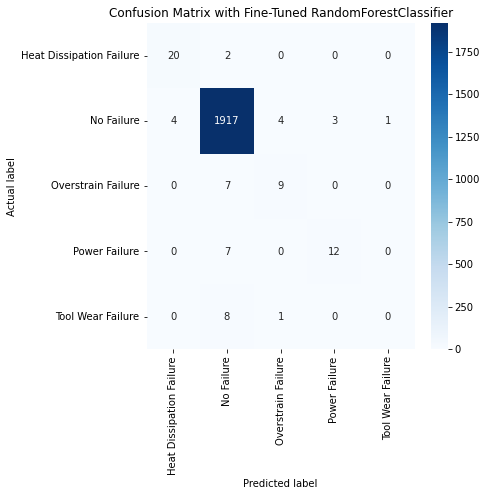

In [233]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Traçons la matrice de confusion
plt.figure(figsize=(6, 6))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_pred))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned RandomForestClassifier')
plt.show()

### Sauvegarde du modèle final

In [54]:
with open('/home/sacko/Documents/Maintenance/ModelFinal.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)